<a href="https://colab.research.google.com/github/AgustinGurvich/TMD/blob/main/TMD_TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajo Práctico 1

Importamos librerias a utilizar

In [3]:
library(MASS)
library(ggplot2)
library(tidyverse)
library(rpart)
library(class)

# Conjunto de datos Diagonal

Funcion que genera un conjunto de datos tipo diagonal

In [4]:
diagonal <- function(n,d,C){
std_dev <- C * sqrt(d) 
covariance_matrix = diag(std_dev, d, d)
centerClass1 = rep(1, times=d)
centerClass0 = rep(-1, times=d)
size1 = floor(n/2)
size0 = ceiling(n/2)
points1 <- mvrnorm(size1, centerClass1, covariance_matrix)
points0 <- mvrnorm(size0, centerClass0, covariance_matrix)
class1 <- cbind(points1, rep(1, times=d))
class0 <- cbind(points0, rep(0, times=d))
columnNames <- c(paste0("d", seq(1,d)),"class")
f <- as.data.frame(rbind(class0,class1))
colnames(f) <- columnNames
return (f)
}

Generamos los datos diagonales necesarios

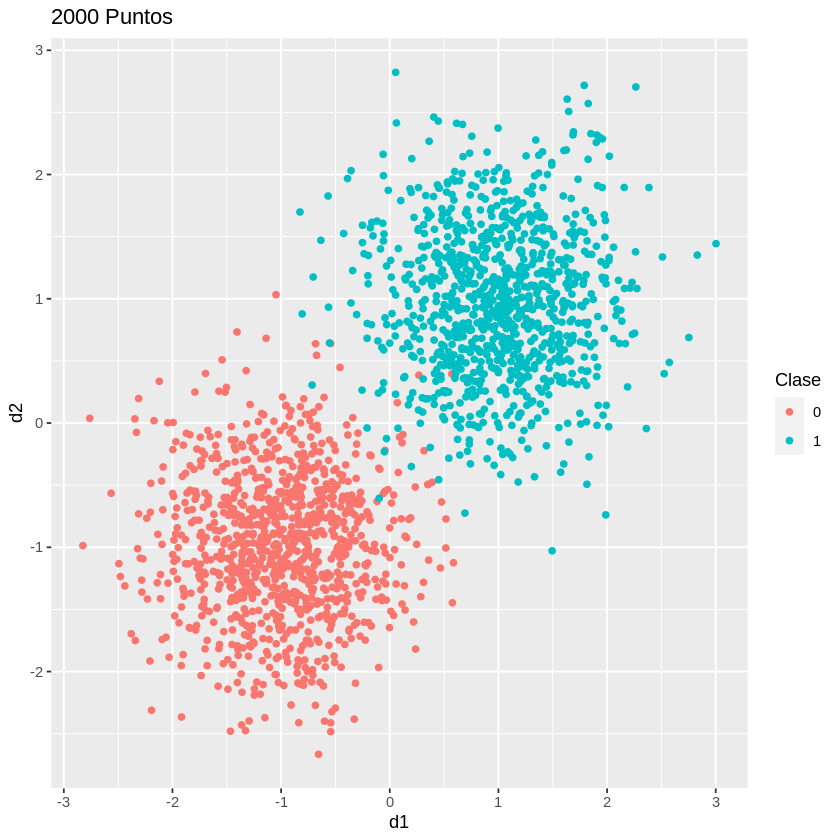

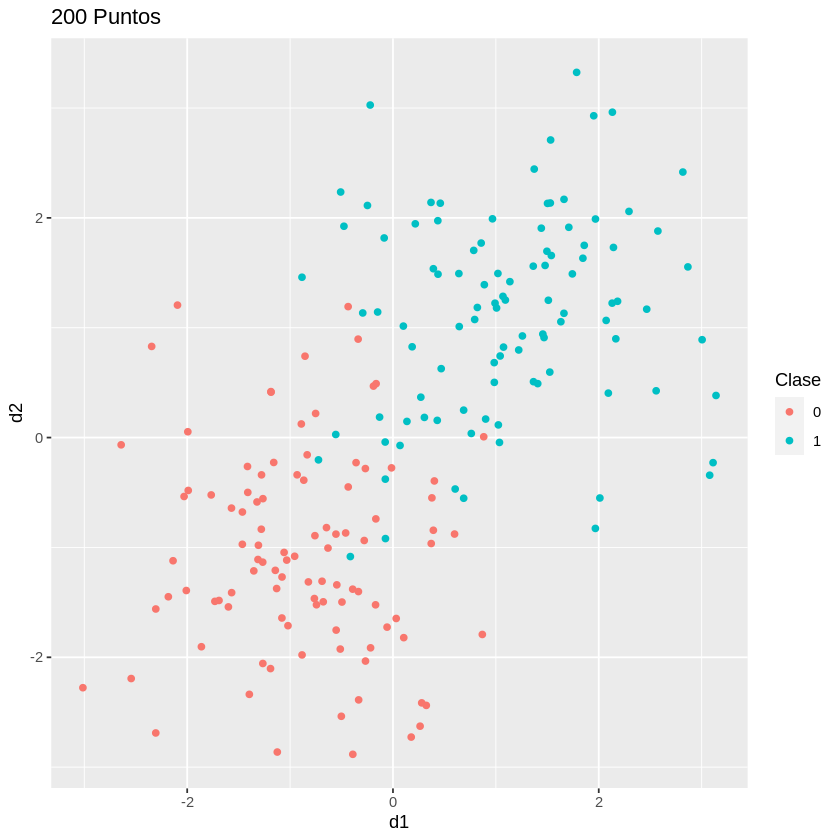

In [5]:
diagTest <- diagonal(2000,2,0.25)
diagTest$class <- as.factor(diagTest$class)
ggplot(diagTest, 
       aes(x=d1, 
           y=d2,
           color = factor(class))) +
  geom_point() + 
  labs(title = "2000 Puntos", colour  = "Clase")

diagTrain <- diagonal(200,2,0.5)
diagTrain$class <- as.factor(diagTrain$class)
ggplot(diagTrain, 
       aes(x=d1, 
           y=d2,
           color = factor(class))) +
  geom_point() + 
  labs(title = "200 Puntos", colour  = "Clase")

# Clasificación con árboles de decisión 

Clasificando el conjunto de datos diagonal utilizando árboles de decisión y un test simple



In [48]:
arbolDiag <- rpart(formula = class ~ ., data = diagTrain)
predictDiagSimple <- predict(arbolDiag, newdata=diagTest[-3], type = "class")
confusionArbolSimple <- table(predictDiagSimple, diagTest[,3])
print(confusionArbolSimple)
errorSimple <- (confusionSimple[2,1] + confusionSimple[1,2]) / 2000
print(paste("El porcentaje de error en el caso de test simple fue:",errorSimple))

                 
predictDiagSimple   0   1
                0 972  12
                1  28 988
[1] "El porcentaje de error en el caso de test simple fue: 0.0225"


Clasificando el conjunto de datos diagonal utilizando árboles de decisión y 5-fold cross-validation


In [16]:
#sample(n), si n es un numero natural y no se especifica el tamanio, genera una permutacion de los numeros entre 1 y n
#En este caso, es el conjunto de test pero mezclado aleatoriamente
diagSetSampled <- diagTrain[sample(nrow(diagTrain)),]

#Creamos un arreglo de indices que representa los folds
foldsIndex <- cut(seq(1,nrow(diagSetSampled)),breaks=5,labels=FALSE)

# Para guardar los errores
errors <- c()

#5-fold cross-validation
for(i in 1:5){
    #Buscamos los indices del fold correspondiente 
    testIndexes <- which(foldsIndex==i,arr.ind=TRUE)
    # Generamos los conjuntos de test y train
    testData <- diagSetSampled[testIndexes, ]
    trainData <- diagSetSampled[-testIndexes, ]
    #Entrenamos
    arbolDiagFolds <- rpart(formula = class ~ ., data = trainData)
    predictDiagFolds <- predict(arbolDiagFolds, newdata=testData[-3], type = "class")
    #Matriz de confusion
    confusion <- table(predictDiagFolds, testData[,3])
    print(paste("Matriz de confusión en la iteración número ",i))
    print(confusion)
    #Guardamos los errores
    errors <- c(errors, (confusion[2,1] + confusion[1,2]) / 40)
}
print("Errores en cada iteración:")
print(errors)
print(paste("Promedio de los errores: ", sum(errors)/5))

[1] "Matriz de confusión en la iteración número  1"
                
predictDiagFolds  0  1
               0 18  2
               1  1 19
[1] "Matriz de confusión en la iteración número  2"
                
predictDiagFolds  0  1
               0 23  3
               1  0 14
[1] "Matriz de confusión en la iteración número  3"
                
predictDiagFolds  0  1
               0 17  5
               1  2 16
[1] "Matriz de confusión en la iteración número  4"
                
predictDiagFolds  0  1
               0 21  1
               1  2 16
[1] "Matriz de confusión en la iteración número  5"
                
predictDiagFolds  0  1
               0 14  0
               1  2 24
[1] "Errores en cada iteración:"
[1] 0.075 0.075 0.175 0.075 0.050
[1] "Promedio de los errores:  0.09"


Conclusiones: El entrenamiento en 5-fold cross-validation trajo resultados con un error de 0.09% contra el 0.02% del entrenamiento con el conjunto completo.

Creo que estos valores pueden darse por el hecho de estar utilizando un conjunto de entrenamiento significativamente más pequeño (20%) en cada paso de  la iteración del entrenamiento. Aún así, podemos observar que en cada uno de los 5 árboles generados el error fue menor al 10% (excepto en la iteración número 3).

Dentro de todo, creo que el resultado del entrenamiento es bastante satisfactorio.

# Clasificación con K-Vecinos

Clasificando el conjunto de datos diagonal utilizando K-vecinos y un test simple

In [51]:
knnDiag <- knn(diagTrain[,-3], test = diagTest[,-3], cl=diagTrain[,3], k=3)
confusionKnnSimple <- table(knnDiag, diagTest[,3])
print(confusionKnnSimple)
errorKnnSimple <- (confusionKnnSimple[2,1] + confusionKnnSimple[1,2]) / 2000
print(paste("El porcentaje de error en el caso de test simple fue:",errorKnnSimple))

       
knnDiag   0   1
      0 973  18
      1  27 982
[1] "El porcentaje de error en el caso de test simple fue: 0.0225"


Clasificando el conjunto de datos diagonal utilizando K-vecinos y 5-fold cross-validation


In [72]:
diagSetSampled <- diagTrain[sample(nrow(diagTrain)),]

#Creamos un arreglo de indices que representa los folds
foldsIndex <- cut(seq(1,nrow(diagSetSampled)),breaks=5,labels=FALSE)

# Para guardar los errores
errors <- c()

#5-fold cross-validation
for(i in 1:5){
    #Buscamos los indices del fold correspondiente 
    testIndexes <- which(foldsIndex==i,arr.ind=TRUE)
    # Generamos los conjuntos de test y train
    testData <- diagSetSampled[testIndexes, ]
    trainData <- diagSetSampled[-testIndexes, ]
    #Entrenamos
    knnDiagFolds <- knn(trainData[,-3], test = testData[,-3], cl=trainData[,3], k=3)
    #predictDiagFolds <- predict(arbolDiagFolds, newdata=testData[-3], type = "class")
    #Matriz de confusion
    confusion <- table(knnDiagFolds, testData[,3])
    print(paste("Matriz de confusión en la iteración número ",i))
    print(confusion)
    #Guardamos los errores
    errors <- c(errors, (confusion[2,1] + confusion[1,2]) / 40)
}
print("Errores en cada iteración:")
print(errors)
print(paste("Promedio de los errores: ", sum(errors)/5))

[1] "Matriz de confusión en la iteración número  1"
            
knnDiagFolds  0  1
           0 19  1
           1  1 19
[1] "Matriz de confusión en la iteración número  2"
            
knnDiagFolds  0  1
           0 18  2
           1  1 19
[1] "Matriz de confusión en la iteración número  3"
            
knnDiagFolds  0  1
           0 23  3
           1  0 14
[1] "Matriz de confusión en la iteración número  4"
            
knnDiagFolds  0  1
           0 14  1
           1  3 22
[1] "Matriz de confusión en la iteración número  5"
            
knnDiagFolds  0  1
           0 20  1
           1  1 18
[1] "Errores en cada iteración:"
[1] 0.050 0.075 0.075 0.100 0.050
[1] "Promedio de los errores:  0.07"


Conclusiones: El entrenamiento en 5-fold cross-validation trajo resultados con un error de 0.07% contra el 0.02% del entrenamiento con el conjunto completo.

Estamos frente a una situación muy similar al caso del entrenamiento con árboles de decisión (aunque bastante mejor), y creo que los resultados se deben a razones similares.

Algo que creo que es interesante destacar es que durante las pruebas que hice al entrenamiento por K-vecinos, obtuve resultados bastante dispares en el caso del 5-fold cross-validations: Promedios de erroes que variaban entre 0.05 y 0.1, pero que parecían estabilizarse cerca del 0.08 


# Conjunto de datos Espiral

Funcion que genera un conjunto de datos tipo espiral

In [17]:
f1 <- function(theta){
  return (theta/(4*pi))
}

f2 <- function(theta){
  return ((theta + pi)/ (4*pi))
}

espiral <- function(n){
  #Buscamos generar n puntos: la mitad de cada clase
  size0 <- floor(n/2)
  size1 <- ceiling(n/2)

  #¿Cuantos de cada clase generamos?
  acumClass0 <- 0
  acumClass1 <- 0

  #Dataframe a crear
  points <- data.frame()

  #Valor 2 * pi
  pi2 <- 2 * pi  

  #Empezamos a generar puntos hasta llenar las clases
  while(acumClass0 < size0 || acumClass1 < size1){
    #Armamos un punto en coordenadas polares
    r <- sqrt(runif(1,0,1))
    theta <-  pi2 * runif(1,0,1)

    #Usamos estos valores para recorres las curvas y revisar que el punto se 
    #encuentre entre ellas
    circleLoops <- seq(-1,5,1)
    circleLoops <- (circleLoops * pi2) + theta
    #Para guardar a que clase pertenece
    between = F

    for(loop in circleLoops){
      if(f1(loop) < r && r < f2(loop)){ #Esta comprendido entre curvas
        if(acumClass0 < size0){ #¿Lo tengo que almacenar?
          x <- r * cos(theta)
          y <- r * sin(theta)
          acumClass0 <- acumClass0 + 1
          points <- rbind(points, c(x,y,0))
        }
        between = T
      }
    }

    #Si no estaba entre las curvas, entonces es de la clase 1
    if(acumClass1 < size1 && !between){
      x <- r * cos(theta)
      y <- r * sin(theta)
      acumClass1 <- acumClass1 + 1
      points <- rbind(points, c(x,y,1))
    }
    
  }

  colnames(points) <- c("x", "y", "class")

  return (points)
}

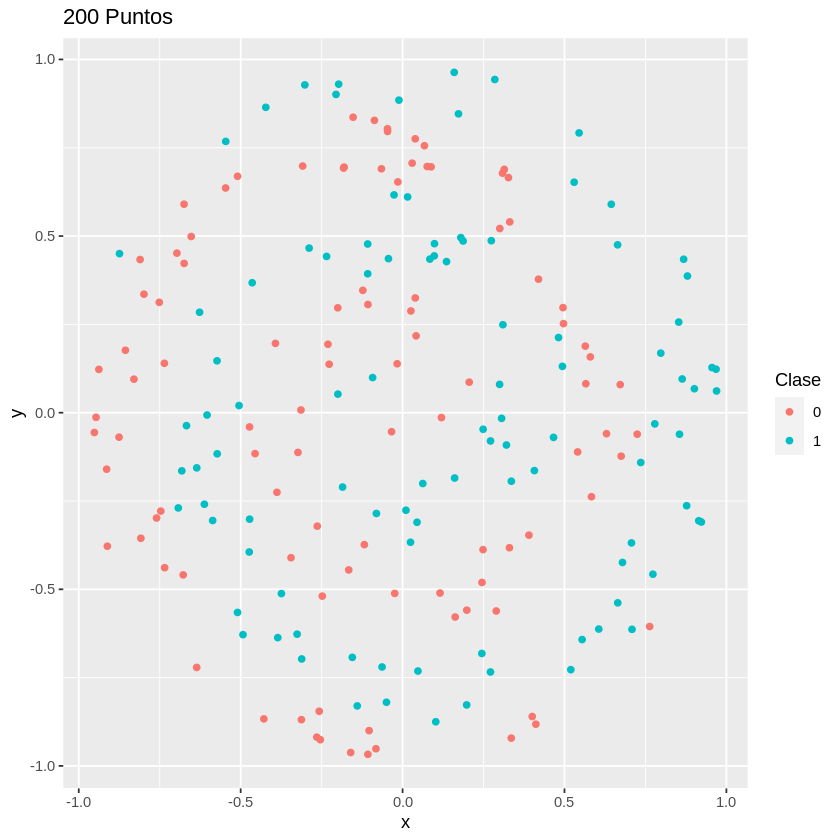

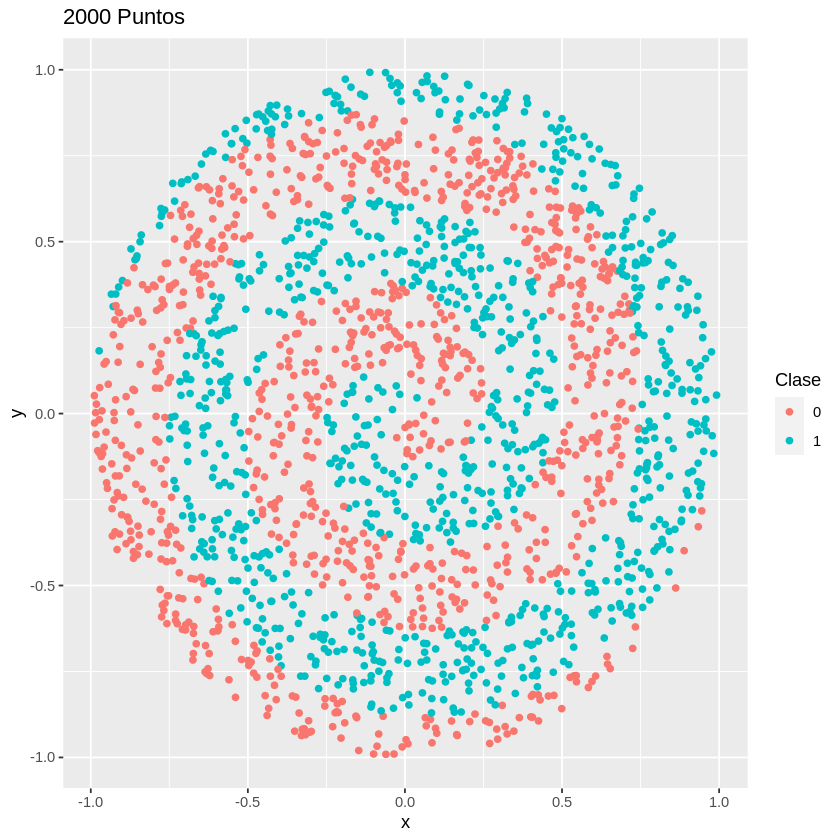

In [30]:
spiralTrain <- espiral(200)
spiralTrain$class <- as.factor(spiralTrain$class)
ggplot(spiralTrain, 
       aes(x=x, 
           y=y, 
           color = factor(class))) +
  geom_point() + 
  labs(title = "200 Puntos", colour  = "Clase") 

spiralTest <- espiral(2000)
spiralTest$class <- as.factor(spiralTest$class)
ggplot(spiralTest, 
       aes(x=x, 
           y=y, 
           color = factor(class))) +
  geom_point() + 
  labs(title = "2000 Puntos", colour  = "Clase") 

# Clasificación con árboles de decisión 

Clasificando el conjunto de datos espiral utilizando árboles de decisión y un test simple

In [33]:
arbolSpiral <- rpart(formula = class ~ ., data = spiralTrain)
predictSpiralSimple <- predict(arbolSpiral, newdata=spiralTest[-3], type = "class")
confusionSimple <- table(predictSpiralSimple, spiralTest[,3])
print(confusionSimple)
errorSimple <- (confusionSimple[2,1] + confusionSimple[1,2]) / 2000
print(paste("El porcentaje de error en el caso de test simple fue:",errorSimple))

                   
predictSpiralSimple   0   1
                  0 711 296
                  1 289 704
[1] "El porcentaje de error en el caso de test simple fue: 0.2925"


Clasificando el conjunto de datos espiral utilizando árboles de decisión y 5-fold cross-validation

In [41]:
spiralSetSampled <- spiralTrain[sample(nrow(spiralTrain)),]

#Creamos un arreglo de indices que representa los folds
foldsIndex <- cut(seq(1,nrow(spiralSetSampled)),breaks=5,labels=FALSE)

# Para guardar los errores
errors <- c()

#5-fold cross-validation
for(i in 1:5){
    #Buscamos los indices del fold correspondiente 
    testIndexes <- which(foldsIndex==i,arr.ind=TRUE)
    # Generamos los conjuntos de test y train
    testData <- spiralSetSampled[testIndexes, ]
    trainData <- spiralSetSampled[-testIndexes, ]
    #Entrenamos
    arbolSpiralFolds <- rpart(formula = class ~ ., data = trainData)
    predictSpiralFolds <- predict(arbolSpiralFolds, newdata=testData[-3], type = "class")
    #Matriz de confusion
    confusion <- table(predictSpiralFolds, testData[,3])
    print(paste("Matriz de confusión en la iteración número ",i))
    print(confusion)
    #Guardamos los errores
    errors <- c(errors, (confusion[2,1] + confusion[1,2]) / 40)
}
print("Errores en cada iteración:")
print(errors)
print(paste("Promedio de los errores: ", sum(errors)/5))

[1] "Matriz de confusión en la iteración número  1"
                  
predictSpiralFolds  0  1
                 0 13 10
                 1  7 10
[1] "Matriz de confusión en la iteración número  2"
                  
predictSpiralFolds  0  1
                 0 15  6
                 1  6 13
[1] "Matriz de confusión en la iteración número  3"
                  
predictSpiralFolds  0  1
                 0 14  6
                 1  5 15
[1] "Matriz de confusión en la iteración número  4"
                  
predictSpiralFolds  0  1
                 0 13  7
                 1  6 14
[1] "Matriz de confusión en la iteración número  5"
                  
predictSpiralFolds  0  1
                 0 17  5
                 1  4 14
[1] "Errores en cada iteración:"
[1] 0.425 0.300 0.275 0.325 0.225
[1] "Promedio de los errores:  0.31"


Conclusiones: En este caso, la diferencia entre los tipos de entrenamiento de los árboles es mucho menor que en el dataset anterior, aunque el error en general sigue siendo muy alto (cerca del 30%). 

Creo que ambos proveen resultados satisfactorios, pero es evidente que es posible obtener modelos decentes utilizando un dataset más pequeño.

# Clasificación con K-Vecinos 

Clasificando el conjunto de datos espiral utilizando K-vecinos y un test simple

In [76]:
knnDiag <- knn(spiralTrain[,-3], test = spiralTest[,-3], cl=spiralTrain[,3], k=3)
confusionKnnSimple <- table(knnDiag, spiralTest[,3])
print(confusionKnnSimple)
errorKnnSimple <- (confusionKnnSimple[2,1] + confusionKnnSimple[1,2]) / 2000
print(paste("El porcentaje de error en el caso de test simple fue:",errorKnnSimple))

       
knnDiag   0   1
      0 820 159
      1 180 841
[1] "El porcentaje de error en el caso de test simple fue: 0.1695"


Clasificando el conjunto de datos espiral utilizando K-vecinos y 5-fold cross-validation

In [98]:
spiralSetSampled <- spiralTrain[sample(nrow(spiralTrain)),]

#Creamos un arreglo de indices que representa los folds
foldsIndex <- cut(seq(1,nrow(spiralSetSampled)),breaks=5,labels=FALSE)

# Para guardar los errores
errors <- c()

#5-fold cross-validation
for(i in 1:5){
    #Buscamos los indices del fold correspondiente 
    testIndexes <- which(foldsIndex==i,arr.ind=TRUE)
    # Generamos los conjuntos de test y train
    testData <- spiralSetSampled[testIndexes, ]
    trainData <- spiralSetSampled[-testIndexes, ]
    #Entrenamos
    knnDiagFolds <- knn(trainData[,-3], test = testData[,-3], cl=trainData[,3], k=3)
    #Matriz de confusion
    confusion <- table(knnDiagFolds, testData[,3])
    print(paste("Matriz de confusión en la iteración número ",i))
    print(confusion)
    #Guardamos los errores
    errors <- c(errors, (confusion[2,1] + confusion[1,2]) / 40)
}
print("Errores en cada iteración:")
print(errors)
print(paste("Promedio de los errores: ", sum(errors)/5))

[1] "Matriz de confusión en la iteración número  1"
            
knnDiagFolds  0  1
           0 16  6
           1  3 15
[1] "Matriz de confusión en la iteración número  2"
            
knnDiagFolds  0  1
           0 19  5
           1  5 11
[1] "Matriz de confusión en la iteración número  3"
            
knnDiagFolds  0  1
           0 15  5
           1  3 17
[1] "Matriz de confusión en la iteración número  4"
            
knnDiagFolds  0  1
           0 19  4
           1  2 15
[1] "Matriz de confusión en la iteración número  5"
            
knnDiagFolds  0  1
           0 15  3
           1  3 19
[1] "Errores en cada iteración:"
[1] 0.225 0.250 0.200 0.150 0.150
[1] "Promedio de los errores:  0.195"


In [ ]:
En este caso, los entrenamientos son mucho más satisfactorios que utilizando árboles.
Durante las iteraciones que realicé, no encontré una aproximación en 5-fold cross-validation tan buena como la que se da en el entrenamiento y test con los otros datasets.
Esto me hace pensar que, al ser un dataset mucho más complicado que el diagonal, es necesaria mayor cantidad de información para obtener buenos resultados